# リポジトリクローン

In [ ]:
!git clone https://github.com/xuebinqin/U-2-Net

In [ ]:
%cd U-2-Net

# 訓練済みモデルダウンロード

In [ ]:
!mkdir -p saved_models/u2net
!mkdir -p saved_models/u2netp
!mkdir -p saved_models/u2net_portrait
!mkdir -p saved_models/u2net_human_seg

In [ ]:
import gdown

gdown.download('https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ', 'saved_models/u2net/u2net.pth', quiet=False)
gdown.download('https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy', 'saved_models/u2netp/u2netp.pth', quiet=False)
gdown.download('https://drive.google.com/uc?id=1IG3HdpcRiDoWNookbncQjeaPN28t90yW', 'saved_models/u2net_portrait/u2net_portrait.pth', quiet=False)
gdown.download('https://drive.google.com/uc?id=1-Yg0cxgrNhHP-016FPdp902BR-kSsA4P', 'saved_models/u2net_human_seg/u2net_human_seg.pth', quiet=False)

# ONNX変換関連インストール

In [ ]:
!pip install onnx-simplifier

In [ ]:
def convert_to_onnx(net, file_name='output.onnx', input_shape=(512, 512), device='cpu'):
    input = torch.randn(1, 3, input_shape[0], input_shape[1]).to(device)

    input_layer_names = ['input_image']
    output_layer_names = ['output_image']

    torch.onnx.export(
        net, 
        input, 
        file_name, 
        verbose=True,
        opset_version=13,
        input_names=input_layer_names,
        output_names=output_layer_names,
    )

In [ ]:
!pip install onnxruntime imread_from_url

# u2net

In [ ]:
import torch

from model import U2NET

In [ ]:
# モデルロード
model_path = 'saved_models/u2net/u2net.pth'

model = U2NET(3,1)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
model.to('cpu')

In [ ]:
# 入力画像の一辺の長さ
side_length = 320

# ONNX変換
convert_to_onnx(model, 'u2net.onnx', (side_length, side_length), 'cpu')

In [ ]:
!python -m onnxsim u2net.onnx u2net.onnx

In [ ]:
# ONNXモデルロード
import onnxruntime

onnx_session = onnxruntime.InferenceSession('u2net.onnx')

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [ ]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/BASNet-ONNX-Sample/main/sample.png')

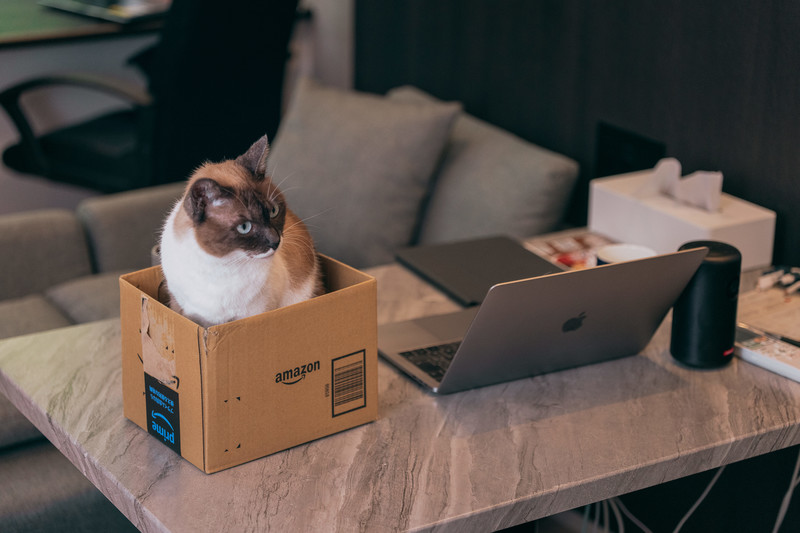

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [ ]:
%%time
# 推論テスト
import cv2 as cv
import numpy as np

# 前処理
input_image = cv.resize(image, dsize=(side_length, side_length))  # リサイズ
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)  # BGR→RGB変換

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (input_image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')

# (1, 3, Height, Width)形式へリシェイプ
x = x.reshape(-1, 3, side_length, side_length)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (onnx_result - np.min(onnx_result)) / (np.max(onnx_result) - np.min(onnx_result))
onnx_result *= 255

CPU times: user 2.04 s, sys: 64.1 ms, total: 2.1 s
Wall time: 2.13 s


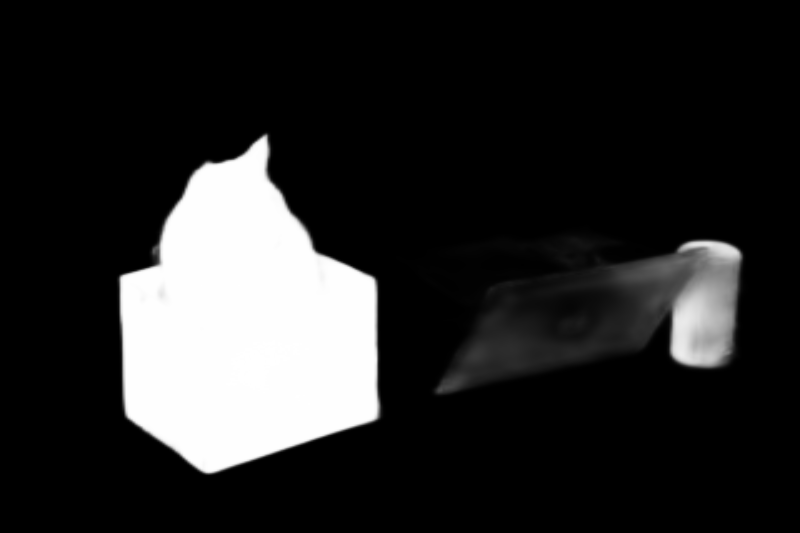

In [ ]:
display_image = cv.resize(onnx_result, dsize=(image.shape[1], image.shape[0]))  # リサイズ
cv2_imshow(display_image)

# u2netp

In [ ]:
import torch

from model import U2NETP

In [ ]:
# モデルロード
model_path = 'saved_models/u2netp/u2netp.pth'

model = U2NETP(3,1)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
model.to('cpu')

In [ ]:
# 入力画像の一辺の長さ
side_length = 320

# ONNX変換
convert_to_onnx(model, 'u2netp.onnx', (side_length, side_length), 'cpu')

In [ ]:
!python -m onnxsim u2netp.onnx u2netp.onnx

In [ ]:
# ONNXモデルロード
import onnxruntime

onnx_session = onnxruntime.InferenceSession('u2netp.onnx')

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [ ]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/BASNet-ONNX-Sample/main/sample.png')

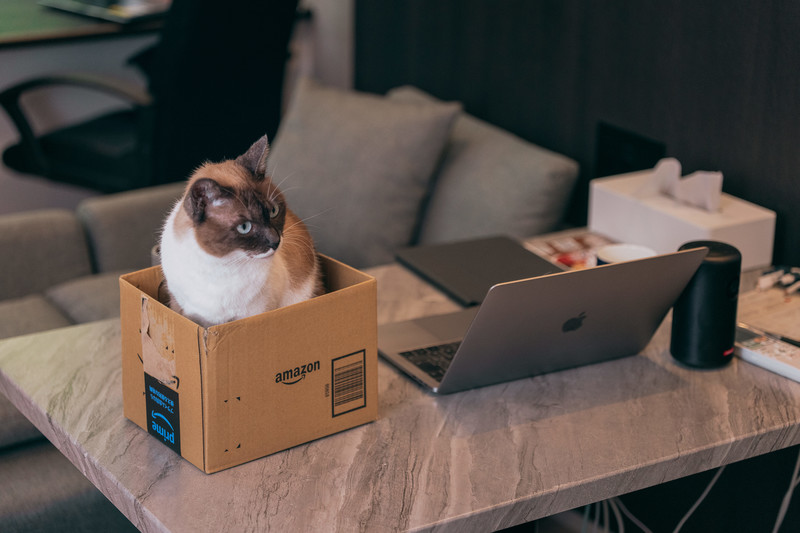

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [ ]:
%%time
# 推論テスト
import cv2 as cv
import numpy as np

# 前処理
input_image = cv.resize(image, dsize=(side_length, side_length))  # リサイズ
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)  # BGR→RGB変換

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (input_image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')

# (1, 3, Height, Width)形式へリシェイプ
x = x.reshape(-1, 3, side_length, side_length)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (onnx_result - np.min(onnx_result)) / (np.max(onnx_result) - np.min(onnx_result))
onnx_result *= 255

CPU times: user 880 ms, sys: 46.5 ms, total: 927 ms
Wall time: 936 ms


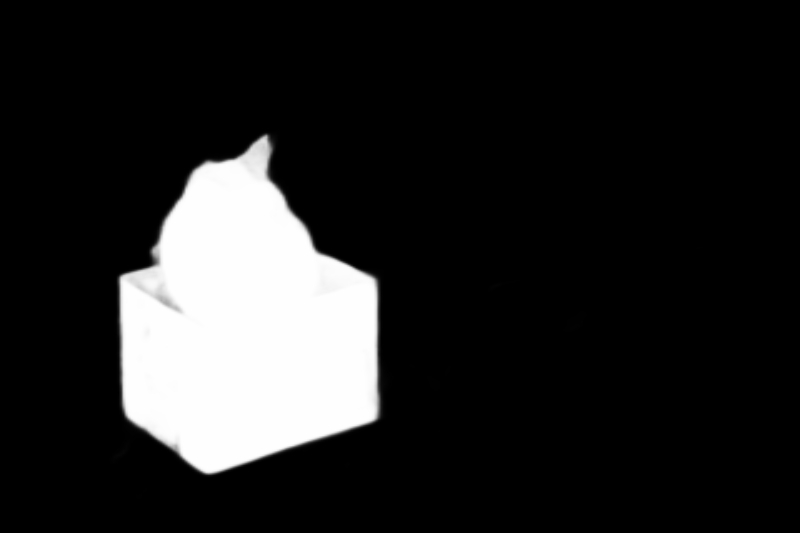

In [ ]:
display_image = cv.resize(onnx_result, dsize=(image.shape[1], image.shape[0]))  # リサイズ
cv2_imshow(display_image)

# u2net_portrait

In [ ]:
import torch

from model import U2NET

In [ ]:
# モデルロード
model_path = 'saved_models/u2net_portrait/u2net_portrait.pth'

model = U2NET(3,1)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
model.to('cpu')

In [ ]:
# 入力画像の一辺の長さ
side_length = 512

# ONNX変換
convert_to_onnx(model, 'u2net_portrait.onnx', (side_length, side_length), 'cpu')

In [ ]:
!python -m onnxsim u2net_portrait.onnx u2net_portrait.onnx

In [ ]:
# ONNXモデルロード
import onnxruntime

onnx_session = onnxruntime.InferenceSession('u2net_portrait.onnx')

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [ ]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

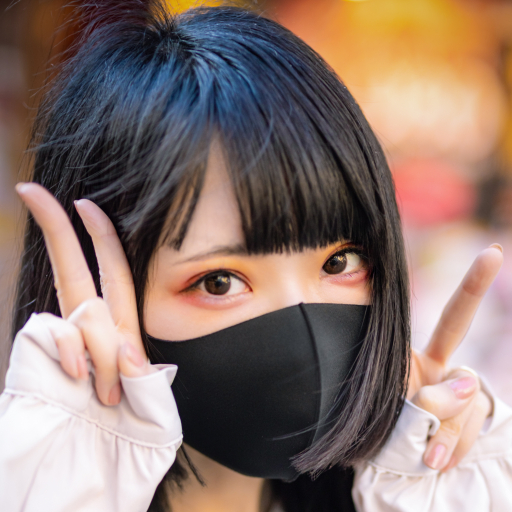

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [ ]:
%%time
# 推論テスト
import cv2 as cv
import numpy as np

# 前処理
input_image = cv.resize(image, dsize=(side_length, side_length))  # リサイズ
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)  # BGR→RGB変換

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (input_image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')

# (1, 3, Height, Width)形式へリシェイプ
x = x.reshape(-1, 3, side_length, side_length)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (1 - onnx_result)
onnx_result = (onnx_result - np.min(onnx_result)) / (np.max(onnx_result) - np.min(onnx_result))
onnx_result *= 255

CPU times: user 5.26 s, sys: 167 ms, total: 5.43 s
Wall time: 5.42 s


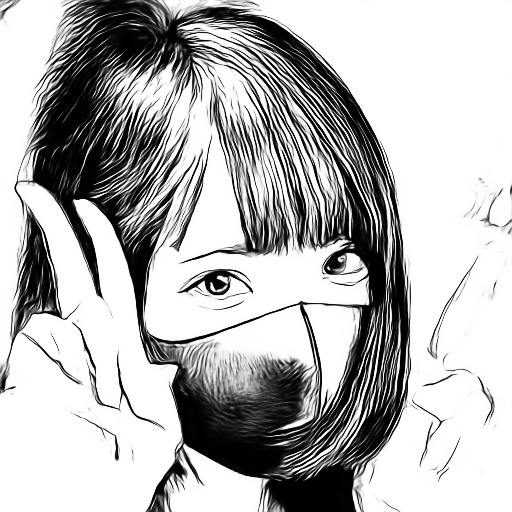

In [ ]:
display_image = cv.resize(onnx_result, dsize=(image.shape[1], image.shape[0]))  # リサイズ
cv2_imshow(display_image)

# u2net_human_seg

In [ ]:
import torch

from model import U2NET

In [ ]:
# モデルロード
model_path = 'saved_models/u2net_human_seg/u2net_human_seg.pth'

model = U2NET(3,1)
model.load_state_dict(torch.load(model_path, map_location='cpu'))
model.eval()
model.to('cpu')

In [ ]:
# 入力画像の一辺の長さ
side_length = 320

# ONNX変換
convert_to_onnx(model, 'u2net_human_seg.onnx', (side_length, side_length), 'cpu')

In [ ]:
!python -m onnxsim u2net_human_seg.onnx u2net_human_seg.onnx

Simplifying...
Checking 0/3...
Checking 1/3...
Checking 2/3...
Ok!


In [ ]:
# ONNXモデルロード
import onnxruntime

onnx_session = onnxruntime.InferenceSession('u2net_human_seg.onnx')

input_name = onnx_session.get_inputs()[0].name
output_name = onnx_session.get_outputs()[0].name

In [ ]:
from imread_from_url import imread_from_url

image = imread_from_url('https://raw.githubusercontent.com/Kazuhito00/AnimeGANv2-ONNX-Sample/main/sample.jpg')

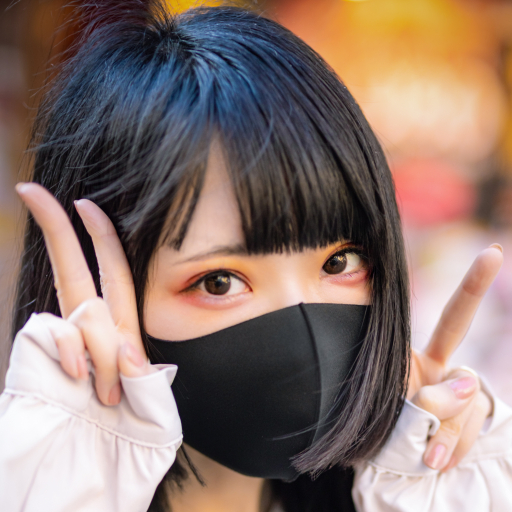

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(image)

In [ ]:
%%time
# 推論テスト
import cv2 as cv
import numpy as np

# 前処理
input_image = cv.resize(image, dsize=(side_length, side_length))  # リサイズ
input_image = cv.cvtColor(input_image, cv.COLOR_BGR2RGB)  # BGR→RGB変換

# 標準化
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
x = (input_image / 255 - mean) / std

# HWC → CHW
x = x.transpose(2, 0, 1).astype('float32')

# (1, 3, Height, Width)形式へリシェイプ
x = x.reshape(-1, 3, side_length, side_length)

# 推論
onnx_result = onnx_session.run([output_name], {input_name: x})

# 後処理
onnx_result = np.array(onnx_result).squeeze()
onnx_result = (onnx_result - np.min(onnx_result)) / (np.max(onnx_result) - np.min(onnx_result))
onnx_result *= 255

CPU times: user 2.06 s, sys: 54.3 ms, total: 2.11 s
Wall time: 2.12 s


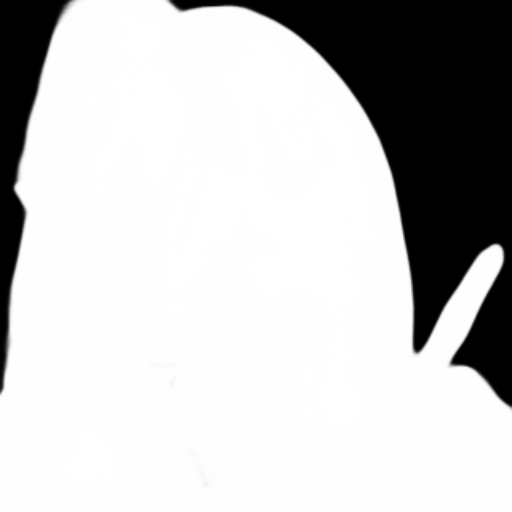

In [ ]:
display_image = cv.resize(onnx_result, dsize=(image.shape[1], image.shape[0]))  # リサイズ
cv2_imshow(display_image)